## Import packages and dependencies

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install mss
!pip install stable-baselines3[extra] protobuf==3.20.*
!pip install numpy matplotlib 
!pip install pytesseract
!pip install gymnasium

In [3]:
from mss import mss                         # screen capture
import pydirectinput                        # keyboard input
import cv2                                  # frame processing
import numpy as np                          # transforming and manipulating arrays
import pytesseract                          # ocr for game over extraction
import matplotlib.pyplot as plt             # visualising captured data
import time                                 # time for pauses

In [4]:
from gymnasium import Env                   # environment components
from gymnasium.spaces import Box, Discrete 

In [5]:
pytesseract.pytesseract.tesseract_cmd = "C:\Program Files\Tesseract-OCR\Tesseract.exe"

## Create environment

In [59]:
class WebGame(Env):
    
    # setup environment
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8) # 83 X 100 pixels image
        self.action_space = Discrete(3)  # 3 discrete actions are available (jump, duck, or do nothing)

        self.cap = mss()
        # specify which region to capture on web page
        self.game_location = {'top':300, 'left':0, 'width':600, 'height':500}  
        self.done_location = {'top':540, 'left':900, 'width':20, 'height':20}

    def step(self, action):
        # Action key - 0: spacebar, 1: down, 2: no_op (do nothing)
        action_map = {
            0:'space',
            1:'down',
            2:'no_op'
        }
        if action != 2:
            pydirectinput.press(action_map[action])
        # check whether the game is over, and get a new observation if so
        done, done_cap = self.get_done()
        new_observation = self.get_observations()
        reward = 1   # reward 1 point for every frame agent stays alive
        info = {}
        truncated = False 
        return new_observation, reward, done, truncated, info
        
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(0) & 0xFF == ord('q'):     # if the key 'q' is pressed, exit the game
            self.close()
            
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observations(), {}

    def seed(self, seed):
        np.random.seed(seed)
        
    def close(self):
        self.running = False
        cv2.destroyAllWindows()
        
    def get_observations(self):
        # get screen capture 
        raw = np.array(self.cap.grab(self.game_location))
        # change image to grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # resize to a 100x83 image (width x height)
        resized = cv2.resize(gray, (100,83))
        # add channels first
        channels = np.reshape(resized, (1,83,100)) # convert to 1 channel, 100x83 image
        return channels
        
    def get_done(self):
        # capture game over screen
        done_cap = np.array(self.cap.grab(self.done_location))
        # valid game over text
        done_strings = ['GAME', 'GAHE']  # this is to account for inaccuracies in ocr of the game over cap, also only 'GAME' is read instead of 'GAME OVER' because pytesseract often inaccurately reads the 'V' and 'E' in the game over screen. This part can be done better with more sophisticated image processing (dilation etc.)
        done = False 
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap


In [60]:
env = WebGame()

In [ ]:
env.reset()

In [22]:
env.render()

In [ ]:
env.get_observations()

In [42]:
env.get_done()

(False,
 array([[[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],
 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],
 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],
 
        ...,
 
        [[252, 252, 252, 255],
         [252, 252, 252, 255],
         [252, 252, 252, 255],
         ...,
         [251, 251, 251, 255],
         [251, 251, 251, 255],
         [251, 251, 251, 255]],
 
        [[251, 251, 251, 255],
         [251, 251, 251, 255],
         [251, 251, 251, 255],
         ...,
         [251, 251, 251, 255],
         [251, 251, 251, 25

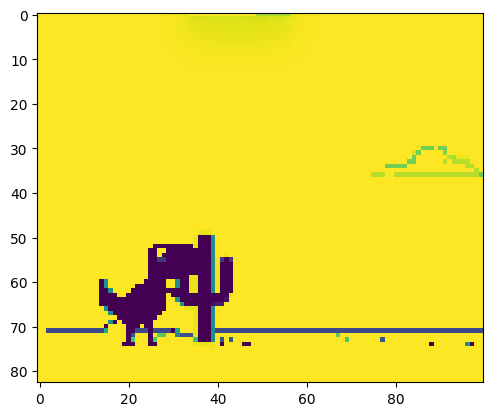

In [10]:
plt.imshow(env.get_observations()[0])

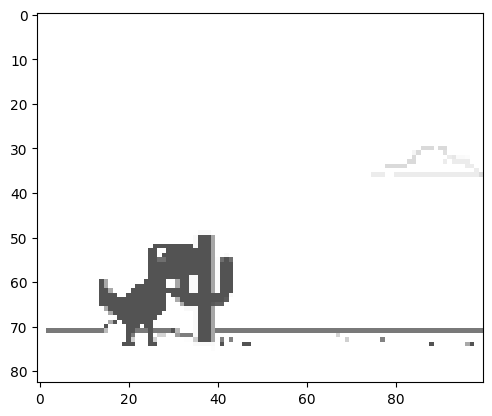

In [11]:
plt.imshow(cv2.cvtColor(env.get_observations()[0], cv2.COLOR_BGR2RGB))

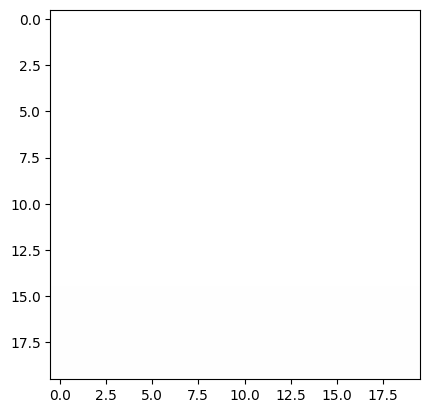

In [64]:
done, done_cap = env.get_done()
plt.imshow(np.array(done_cap))

### Test environment

In [5]:
test_env = WebGame()

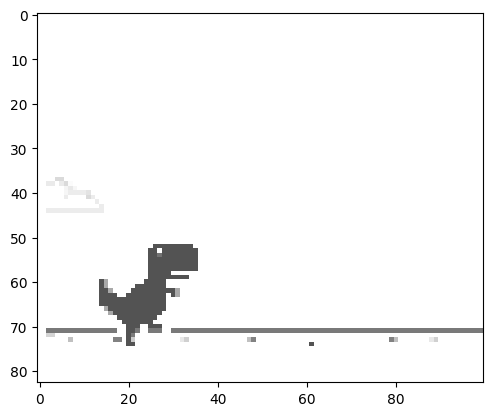

In [5]:
plt.imshow(cv2.cvtColor(test_env.get_observations()[0], cv2.COLOR_BGR2RGB))

In [8]:
done, done_cap = test_env.get_done()

In [10]:
pytesseract.image_to_string(done_cap)

'GAME OVER\n'

In [31]:
num_episodes = 10

for episode in range(num_episodes):
    obs = env.reset()
    done = False 
    total_reward = 0

    while not done:
        obs, reward, done, truncated, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'Total reward for episode {episode+1} is {total_reward}')

Total reward for episode 1 is 13
Total reward for episode 2 is 19
Total reward for episode 3 is 15
Total reward for episode 4 is 14
Total reward for episode 5 is 19
Total reward for episode 6 is 15
Total reward for episode 7 is 12
Total reward for episode 8 is 14
Total reward for episode 9 is 20
Total reward for episode 10 is 14


## Train the model

In [39]:
# import os for file path management 
import os 
# import Callback for saving models 
from stable_baselines3.common.callbacks import CheckpointCallback 
from stable_baselines3 import PPO 

In [37]:
CHECKPOINT_DIR = './train/'  
LOG_DIR = './logs/' 

In [38]:
callback = CheckpointCallback(save_freq=250, save_path=CHECKPOINT_DIR, name_prefix='dqn_model')

### Build DQN and train 

In [11]:
# import the DQN algorithm 
from stable_baselines3 import DQN 

In [34]:
# create the DQN model 
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1,
            buffer_size=120000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [35]:
model.learn(total_timesteps=10000, callback=callback)  
# total_timesteps is like epochs in a normal deep NN. We can increase this number to get a more finely trained model.

Logging to ./logs/DQN_6
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.25     |
|    ep_rew_mean      | 9.25     |
|    exploration_rate | 0.965    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 13       |
|    total_timesteps  | 37       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.62     |
|    ep_rew_mean      | 8.62     |
|    exploration_rate | 0.934    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 26       |
|    total_timesteps  | 69       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.42     |
|    ep_rew_mean      | 8.42     |
|    exploration_rate | 0.904    |
| time/               |        

KeyboardInterrupt: 

**Explanation of some terms**: 
* *Rollout*: Start of interaction between the agent and the environment (the chrome dino game)
* `ep_len_mean`: Mean length of one timestep
* `ep_rew_mean`: Mean reward gained in one timestep
* `exploration_rate`: An exploration rate of 0.934 indicates that the agent chooses a random action approximately 93.4% of the time (high exploration early in training).
* `episodes`: The number of episodes that have been completed so far
* `fps`: Frames per second, or in this case timesteps per second. Can be increased by optimizing the custom environment.
* `time_elapsed`: Time in seconds since the beginning of the training process
* `total_timesteps`: Total number of timesteps since the start of the training process  

## Test out the model

In [ ]:
model.load('./logs/DQN_4/') 


In [18]:
num_episodes = 5

for episode in range(num_episodes): 
    obs = env.reset()
    done = False
    total_reward = 0
    rewards = []
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        total_reward += reward
        rewards.append(reward)
    print('Total Reward for episode {} is {}'.format(episode, total_reward))

ValueError: You have passed a tuple to the predict() function instead of a Numpy array or a Dict. You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) vs `obs = vec_env.reset()` (SB3 VecEnv). See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

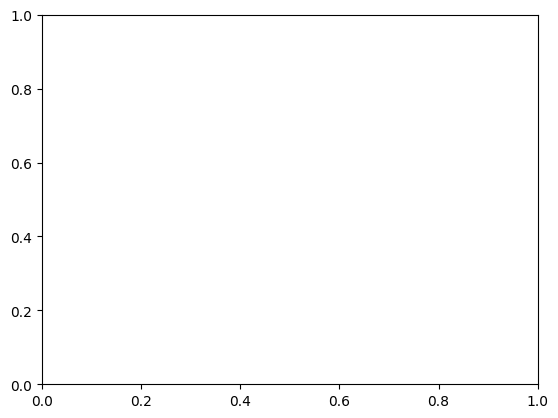

In [36]:
plt.plot(num_episodes, rewards)